In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, BaggingRegressor
from xgboost import XGBRegressor
from src.ml import RegressorFramework
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
asv = pd.read_csv("./data/ASVs.csv", index_col=0)
amino_acid = pd.read_csv("./data/AAs.csv", index_col=0)
fp = pd.read_csv("./data/FPs.csv", index_col=0)
fp = fp[['Moisture', 'TA']]

test_asv = pd.read_csv("./data/test/test_ASVs.csv", index_col=0)
test_amino_acid = pd.read_csv("data/test/test_AAs.csv", index_col=0)
test_fp = pd.read_csv("./data/test/test_FPs.csv", index_col=0)
test_fp = test_fp[['Moisture', 'TA']]

In [3]:
bagging_param_grid = {'n_estimators': [50, 80, 100]}
random_forest_param_grid = {'n_estimators': [50, 80, 100], 'max_depth': [None, 4, 5, 6]}
extra_trees_param_grid = {'n_estimators': [50, 80, 100], 'max_depth': [None, 4, 5, 6]}
adaboost_param_grid = {'n_estimators': [50, 80, 100], 'learning_rate': [0.1, 0.3, 0.5]}
xgboost_param_grid = {'n_estimators': [50, 80, 100], 'learning_rate': [0.1, 0.3, 0.5], 'max_depth': [3, 4, 5]}
param_grids = {
    "Bagging": bagging_param_grid,
    "Random Forest": random_forest_param_grid,
    "Extra Trees": extra_trees_param_grid,
    "AdaBoost": adaboost_param_grid,
    "XGBoost": xgboost_param_grid,
}

In [4]:
models = {
    "Bagging": BaggingRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
}

In [5]:
amino_asv_features = {
    'Gln': {
        'ASV_1': ['B_ASV_15625', 'B_ASV_95119', 'B_ASV_143173', 'B_ASV_48893', 'B_ASV_131779', 'B_ASV_125122'],
        'ASV_2': ['B_ASV_125122', 'B_ASV_77896', 'B_ASV_19290', 'B_ASV_100340', 'B_ASV_38043', 'B_ASV_15625', ]
    },
    'Trp': {
        'ASV_1': ['B_ASV_15625', 'B_ASV_95119', 'B_ASV_143173', 'B_ASV_48893', 'B_ASV_131779', 'B_ASV_125122'],
        'ASV_2': ['B_ASV_48893', 'B_ASV_140470', 'B_ASV_83738', 'B_ASV_38043', 'B_ASV_15625', 'B_ASV_98229', ]
    },
    'Arg': {
        'ASV_1': ['B_ASV_15625', 'B_ASV_95119', 'B_ASV_143173', 'B_ASV_48893', 'B_ASV_131779', 'B_ASV_125122'],
        'ASV_2': ['B_ASV_38043', 'B_ASV_48893', 'B_ASV_143173', 'B_ASV_15625', 'B_ASV_125122', 'B_ASV_79875']
    },
    'Cys': {
        'ASV_1': ['B_ASV_15625', 'B_ASV_95119', 'B_ASV_143173', 'B_ASV_48893', 'B_ASV_131779', 'B_ASV_125122'],
        'ASV_2': ['B_ASV_131779', 'B_ASV_142812', 'B_ASV_143173', 'B_ASV_15625', 'B_ASV_38043', 'B_ASV_137520']
    }
}


In [6]:
amino_acids = amino_asv_features.keys()

results = []

for amino in amino_acids:
    asv_features = amino_asv_features.get(amino, {})
    if not asv_features:
        print(f"Warning: No ASV features defined for {amino}, skipping...")
        continue

    for feature_set in ['ASV_1', 'ASV_2']:
        target_asvs = asv_features.get(feature_set, [])
        if not target_asvs:
            print(f"Warning: No {feature_set} features for {amino}, skipping...")
            continue

        current_asv = asv.loc[:, asv.columns.isin(target_asvs)]
        current_test_asv = test_asv.loc[:, test_asv.columns.isin(target_asvs)]

        X = pd.concat([current_asv, fp], axis=1)
        X_test = pd.concat([current_test_asv, test_fp], axis=1)

        y = amino_acid[amino]
        y_test = test_amino_acid[amino]

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

        for model_name, model in models.items():
            param_grid = param_grids.get(model_name, {})
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
            grid_search.fit(X_train, y_train)

            tuned_model = grid_search.best_estimator_
            reg = RegressorFramework(tuned_model)
            reg.fit(X_train, y_train)

            r2_val, rmse_val, _ = reg.evaluate(X_val, y_val)

            r2_test, rmse_test, y_pred = reg.evaluate(X_test, y_test)

            results.append({
                "Amino_Acid": amino,
                "Feature_Set": feature_set,
                "Model": model_name,
                "R2_Val": r2_val,
                "RMSE_Val": rmse_val,
                "R2_Test": r2_test,
                "RMSE_Test": rmse_test
            })

results_df = pd.DataFrame(results)

<Figure size 1500x800 with 0 Axes>

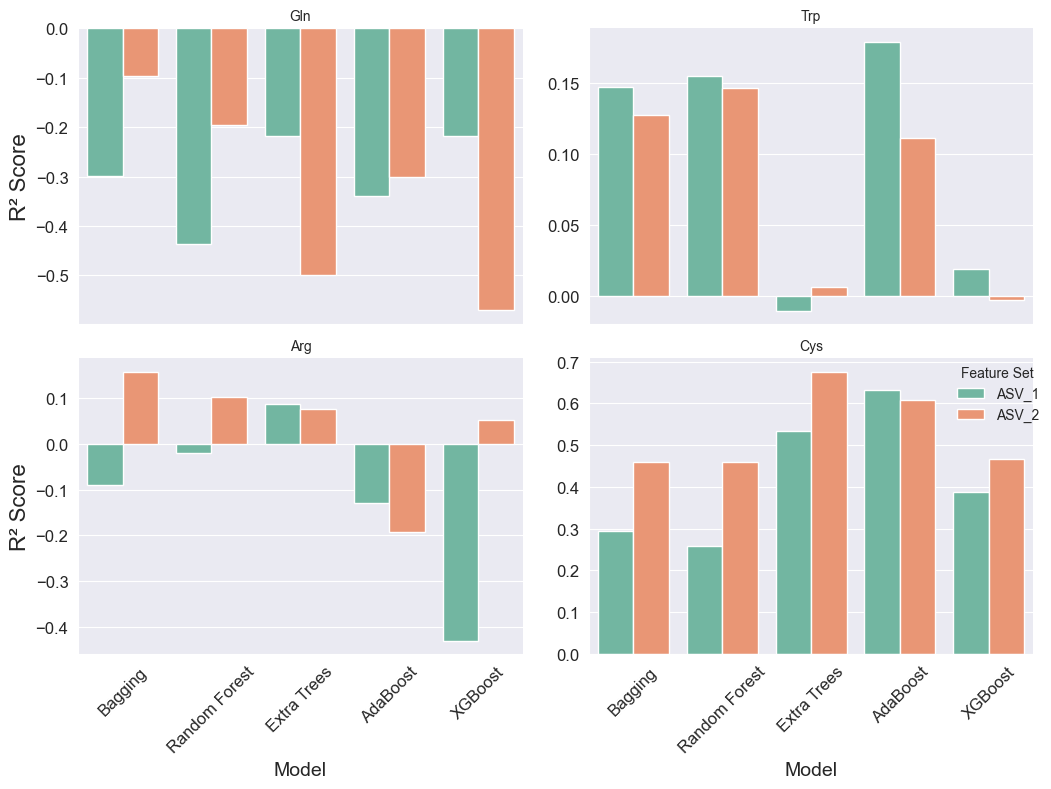

<Figure size 1500x800 with 0 Axes>

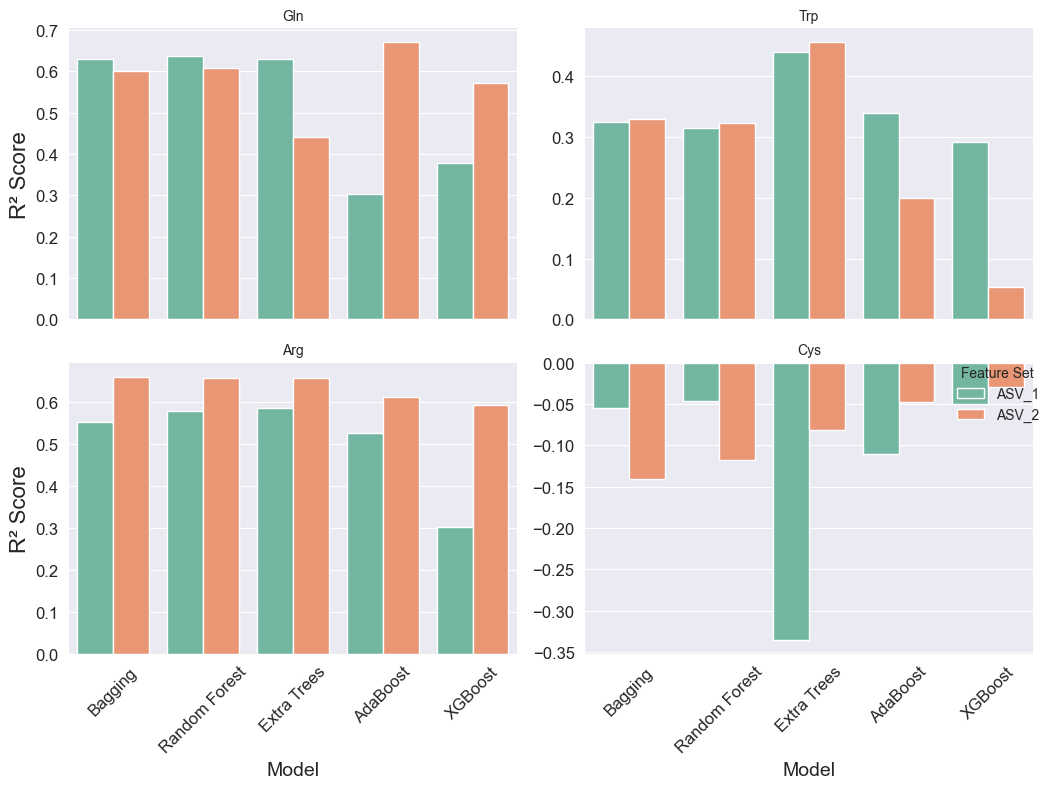

In [7]:
# 数据重塑
melted_df = results_df.melt(
    id_vars=["Amino_Acid", "Feature_Set", "Model"],
    value_vars=["R2_Val", "R2_Test"],
    var_name="Dataset",
    value_name="R2_Score"
)

# 添加可读性更好的数据集标签
melted_df["Dataset"] = melted_df["Dataset"].map({
    "R2_Val": "Validation Set",
    "R2_Test": "Test Set"
})

# 创建分开的图表
for dataset_name, dataset_df in melted_df.groupby("Dataset"):
    plt.figure(figsize=(15, 8))

    # 使用分面网格展示不同氨基酸
    g = sns.FacetGrid(
        dataset_df,
        col="Amino_Acid",
        col_wrap=2,
        height=4,
        aspect=1.2,
        sharey=False
    )

    g.map_dataframe(
        sns.barplot,
        x="Model",
        y="R2_Score",
        hue="Feature_Set",
        palette="Set2",
        order=models.keys()
    )

    g.set_titles("{col_name}", fontsize=56)
    g.set_axis_labels("", "R² Score", fontsize=16)
    g.add_legend(title="Feature Set", title_fontsize=16)
    
    for ax in g.axes.flat:
        ax.tick_params(axis="x", rotation=45, labelsize=12)
        ax.tick_params(axis="y", labelsize=12)
        ax.set_xlabel("Model", fontsize=14)

    # plt.suptitle(f"{dataset_name} R² Scores by Amino Acid", y=1.02)
    # plt.savefig(f"{dataset_name}_R2_Scores.pdf", format="pdf")
    plt.tight_layout()
    plt.show()